### Introduction to CNN ( Convolutional Neural Network)

When dealing with 2D data, such as images, CNN is the preferred model to use

Human eyes capture "lights" hitting the optic nerves and the brain processes the information so we can "see"

![Eyy](eye.png)

In Machine Learning, we have similar concept using Convolutional Neural Network

![Conv](conv.png)

The `Conv2D` layer, think of it like a `filter` that extracts specific features from the image
The `MaxPool2D` layer, think of it as `down sampling` to extract most important features.  Finally the `fully connected layers` classifies the image.

These features should use GPU to expedite the calculations.  If you have CUDA 3.5 or higher supported NVidia card, then look at tensorflow GPU setup URL to install CUDA drivers and cuDNN libraries to take advantage of the GPU for backend processing

https://www.tensorflow.org/install/gpu


If not, but you still have some GPU, such as Raedeon, you can install plaidml to expedite the backend CNN calculation

https://github.com/plaidml/plaidml


In [28]:
import numpy as np
#from tensorflow import keras
import keras

print('keras version:', keras.__version__)
print('keras backend:', keras.backend.backend())
print('keras image format:', keras.backend.image_data_format())

keras version: 2.2.4.1
keras backend: plaidml.keras.backend
keras image format: channels_last


#### Keras comes with common datasets you can use to practice developing models.

Common Datasets and size
1. MNIST (28x28x1)
2. Fashtion MNIST (28x28x1)
3. cifar10 (32x32x3)

We will develop the model to handle above three datasets using configuration


In [29]:
#load data
# chose one and check out the accuracy
# MNIST => about 99.4% accuracy on test data
# Fashion MNIST => about 99.2%
# cifar10 => about 78% and overfits => means this model is not good enough

data = keras.datasets.mnist
#data = keras.datasets.fashion_mnist
#data = keras.datasets.cifar10


In [30]:
(x_train, y_train), (x_test, y_test) = data.load_data()

In [31]:
print('train shape:', x_train.shape)
print('train y:', y_train.shape)
print('test_shape:', x_test.shape)
print('test y:', y_test.shape)


num_labels = len(np.unique(y_train))
image_size = x_train.shape[2]

print('num of labels:', num_labels)
print('image size:', image_size)

# calculate input shape and number of channels
is_channels_first = (keras.backend.image_data_format() == 'channels_first')
shape_len = len(x_train.shape)

if shape_len == 3:
    num_channels = 1
else:
    num_channels = 3

if is_channels_first:
    input_shape = (num_channels , image_szie , image_size)
else:
    input_shape = ( image_size , image_size , num_channels)

print('input shape:', input_shape)

train shape: (60000, 28, 28)
train y: (60000,)
test_shape: (10000, 28, 28)
test y: (10000,)
num of labels: 10
image size: 28
input shape: (28, 28, 1)


In [32]:
# convert the shape of data depending on the image data format

if is_channels_first :
    x_train2 = x_train.reshape(x_train.shape[0], num_channels, image_size, image_size)
    x_test2 = x_test.reshape(x_test.shape[0], num_channels, image_size, image_size)
else:
    x_train2 = x_train.reshape(x_train.shape[0], image_size, image_size, num_channels)
    x_test2 = x_test.reshape(x_test.shape[0], image_size, image_size, num_channels)


In [33]:
# normalize the data: 0.0 to 1.0

x_train2 = x_train2.astype('float32') / 255
x_test2 = x_test2.astype('float32') / 255

#hot encode
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

In [34]:
print("revised x_train shape:", x_train2.shape)
print('revised y_train shape:', y_train2.shape)
print('revised x_test shape:', x_test2.shape)
print('revised y_test shape:', y_test2.shape)
print('input shape:',input_shape)

revised x_train shape: (60000, 28, 28, 1)
revised y_train shape: (60000, 10)
revised x_test shape: (10000, 28, 28, 1)
revised y_test shape: (10000, 10)
input shape: (28, 28, 1)


In [35]:
num_hidden_layers = 512
# for cifar10 dataset, include epochs to 50 or higher
epochs=30
batch_size=256

print('batch size:', batch_size)
print('epochs:', epochs)
print('hidden dense layer size:', num_hidden_layers)

batch size: 256
epochs: 30
hidden dense layer size: 512




displaying few training samples


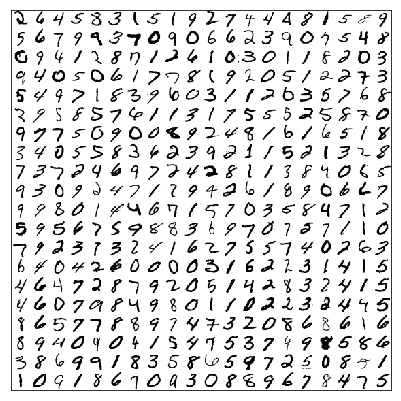

In [36]:
#function to copy 1 image to larger image map
def copy_image(target , ty, tx, src):
    for y in range(image_size):
        for x in range(image_size):
            target[ty*image_size+y][tx*image_size+x] = src[y][x]
    return target

def copy_image32(target , ty , tx , src):
    for y in range(image_size):
        for x in range(image_size):
            target[ty*image_size+y][tx*image_size+x][0] = src[y][x][0]
            target[ty*image_size+y][tx*image_size+x][1] = src[y][x][1]
            target[ty*image_size+y][tx*image_size+x][2] = src[y][x][2]
            
    return target

print('\n\ndisplaying few training samples')

# show 20 x 20
ysize = 20
xsize = 20
start_offset = 0
base_index = start_offset + (ysize * xsize)

if image_size == 28:
    image = np.zeros((image_size*ysize, image_size*xsize), dtype=np.int)
else:
    image = np.zeros( (image_size*ysize , image_size*xsize , 3), dtype=np.int)

for y in range(ysize):
    for x in range(xsize):
        index = y*xsize + x
        src = x_train[index + base_index]
        if image_size == 28:
            image = copy_image(image , y ,x , src)
        else:
            image = copy_image32( image , y, x, src)

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(7,7))
plt.grid(False)
plt.xticks([])
plt.yticks([])
if image_size == 28:
    plt.imshow(image , cmap='gray_r')
else:
    plt.imshow(image)
plt.show()
plt.close()

In [37]:
#model
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=input_shape , activation='relu' ))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add( keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu' ))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add( keras.layers.Dropout(0.5))

model.add( keras.layers.Flatten())
model.add( keras.layers.Dense(num_hidden_layers, activation='relu'))

model.add( keras.layers.Dropout(0.5))
model.add( keras.layers.Dense(10, activation='softmax'))

# compile to model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               819712    
__________

In [38]:
#train the model with train data
fit_history = model.fit(x_train2, y_train2,
  epochs=epochs ,
  batch_size=batch_size,
  validation_data=(x_test2,y_test2)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30


INFO:plaidml:Analyzing Ops: 131 of 249 operations complete


59648/60000 [============================>.] - ETA: 0s - loss: 0.3273 - acc: 0.8980

INFO:plaidml:Analyzing Ops: 84 of 249 operations complete


60000/60000 [==============================] - 13s 220us/step - loss: 0.3264 - acc: 0.8983 - val_loss: 0.0738 - val_acc: 0.9771
Epoch 2/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.1014 - acc: 0.9688 - val_loss: 0.0441 - val_acc: 0.9855
Epoch 3/30
60000/60000 [==============================] - 9s 146us/step - loss: 0.0760 - acc: 0.9761 - val_loss: 0.0349 - val_acc: 0.9881
Epoch 4/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.0625 - acc: 0.9809 - val_loss: 0.0288 - val_acc: 0.9897
Epoch 5/30
60000/60000 [==============================] - 9s 146us/step - loss: 0.0553 - acc: 0.9825 - val_loss: 0.0271 - val_acc: 0.9913
Epoch 6/30
60000/60000 [==============================] - 9s 144us/step - loss: 0.0487 - acc: 0.9846 - val_loss: 0.0220 - val_acc: 0.9919
Epoch 7/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.0468 - acc: 0.9849 - val_loss: 0.0242 - val_acc: 0.9917
Epoch 8/30
60000/60000 [====================

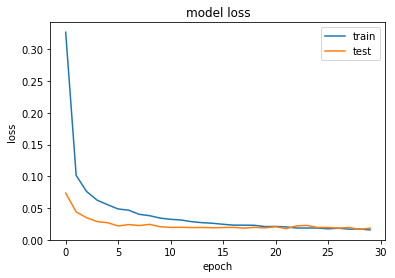

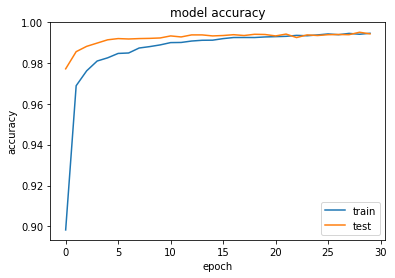

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt

# show procession of training...
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.close()